In [24]:
# This is a Task Description on the steps we actually need to achieve:
"""    
Model Selection:
-   We should start by exploring different kernel functions and their hyperparameters for Gaussian Process (GP) regression. 
    Basically we need to experiment with various kernel functions.
-   According to the assignment we should consider using the marginal likelihood (also known as the evidence) to 
    evaluate the goodness of fit for different kernels and hyperparameters. We need to choose the kernel that 
    maximizes the marginal likelihood.        
    
Large-Scale Learning:
-   Since GP inference can become computationally expensive for large datasets, you should explore strategies to mitigate this issue.
    One option is to consider undersampling, where we randomly select a subset of our data points for model training.       
-   Another option is kernel low-rank approximations, such as the Nyström method or random Fourier features. 

Asymmetric Cost:
-   Also we need to develop a custom decision rule that takes into account the specialized cost function provided. Since the city wants 
    to avoid underestimating pollution concentration, we'll need to assign different costs to false positives and false negatives.
-   We should also consider using techniques like threshold tuning to optimize our model's predictions based on the asymmetric 
    cost function. We could also explore the use of quantile regression or asymmetric loss functions to explicitly address the 
    city's concerns about underestimation.

Validation and Testing:
-   Ensure you have a robust validation and testing framework to evaluate your model's performance. 
    Since it was discussed in the lecture we should consider using techniques like cross-validation.
"""

"    \nModel Selection:\n-   We should start by exploring different kernel functions and their hyperparameters for Gaussian Process (GP) regression. \n    Basically we need to experiment with various kernel functions.\n-   According to the assignment we should consider using the marginal likelihood (also known as the evidence) to \n    evaluate the goodness of fit for different kernels and hyperparameters. We need to choose the kernel that \n    maximizes the marginal likelihood.        \n    \nLarge-Scale Learning:\n-   Since GP inference can become computationally expensive for large datasets, you should explore strategies to mitigate this issue.\n    One option is to consider undersampling, where we randomly select a subset of our data points for model training.       \n-   Another option is kernel low-rank approximations, such as the Nyström method or random Fourier features. \n\nAsymmetric Cost:\n-   Also we need to develop a custom decision rule that takes into account the specia

# Data Analysis

15189


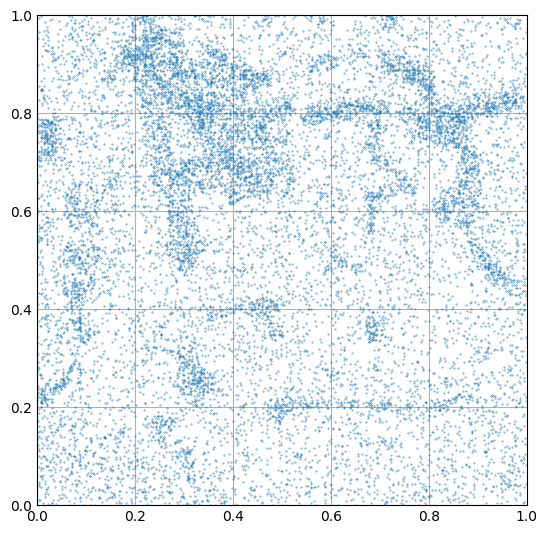

In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor

# Read the CSV file
area_data = pd.read_csv("train_x.csv")
concentration_data = pd.read_csv("train_y.csv")

area_data.head()
concentration_data.head()

# Figures:

plt.style.use('_mpl-gallery')

# Make data
X = area_data.loc[:,'lon']
Y = area_data.loc[:,'lat']
Z = concentration_data.loc[:,'pm25']

print(len(X))

Area = area_data.loc[:,'residential']

# Plot 3D Representation!
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(X, Y, Z)
# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])
# plt.show()


# Plot: 2D Representation!
# levels = np.linspace(Z.min(), Z.max(), 7)

# fig, ax = plt.subplots()
# ax.plot(X, Y, 'o', markersize=0.2, color='black')
# ax.tricontourf(X, Y, Area, levels=levels)
# ax.set(xlim=(0, 1), ylim=(0, 1))
# plt.show()

# fig, ax = plt.subplots(2, 2)
# ax.plot(X, Y, 'o', markersize=0.2, color='black')
# ax.tricontourf(X, Y, Z, levels=levels)
# ax.set(xlim=(0, 1), ylim=(0, 1))
# plt.show()

# Plot: 2D without the contour!
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(X, Y, s = 0.1)
ax.set(xlim=(0, 1), ylim=(0, 1))
plt.show()

# Visualization of the Test Data

In [26]:
Input_test = pd.read_csv("test_x.csv")
X_test_tot = Input_test.loc[:,'lon']
Y_test_tot = Input_test.loc[:,'lat']
Res_test = Input_test.loc[:,'residential']

idx_res_1 = np.nonzero(Res_test)[0]
print("Res = 0:", len(idx_res_1))
print("Res = 0:", len(Res_test)-len(idx_res_1))

# Plot: 2D without the contour!
# fig, ax = plt.subplots()
# ax.scatter(X_test_tot, Y_test_tot, s = 0.1)
# ax.set(xlim=(0, 1), ylim=(0, 1))
# plt.show()

# Clustering Approach:
store_idx = []
radius = 0.01 # Threshold value
for i in range(len(X_test_tot)):
    Dxx = abs(area_data.loc[:,'lon'] - X_test_tot[i]) ** 2
    Dyy = abs(area_data.loc[:,'lat'] - Y_test_tot[i]) ** 2
    Dist = np.sqrt(Dxx + Dyy)

    idx_i = np.where(Dist < radius)[0]
    new_indices = np.setdiff1d(idx_i, store_idx)
    store_idx.extend(new_indices)

print(len(store_idx))


Res = 0: 1464
Res = 0: 1847


10641


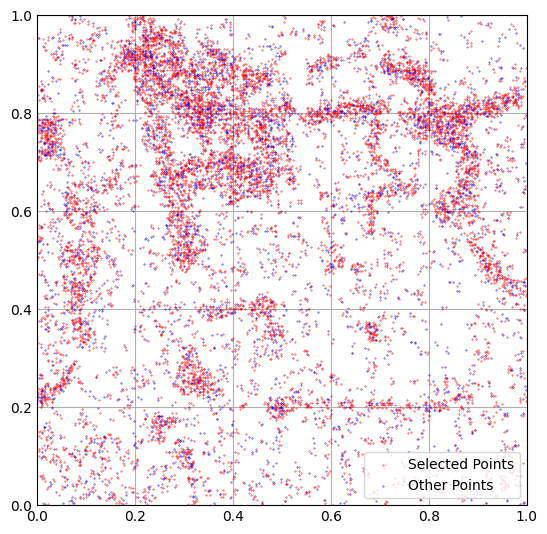

In [27]:
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(area_data.loc[store_idx,'lon'], area_data.loc[store_idx, 'lat'], s=0.1, color='red', label='Selected Points')
ax.scatter(X_test_tot, Y_test_tot, s=0.1, color='blue', label='Other Points')
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.legend() 
plt.show()

clustering = False

if clustering:
    from sklearn.cluster import DBSCAN
    # DBSCAN Parameters:
    eps_par = 0.0075  # Radius
    min_samples_par = 10  # Minimum number of samples

    cluster_labels = {}

    for i in range(len(X_test_tot)):
        P_center = np.column_stack((area_data.loc[store_idx,'lat'] - X_test_tot[i], area_data.loc[store_idx,'lon']- Y_test_tot[i]))
        db = DBSCAN(eps=eps_par, min_samples=min_samples_par).fit(P_center)
        labels = db.labels_
        cluster_labels[i] = labels # These are the cluster labels that will be stored



In [28]:
if clustering: 
    idx_cluster = []
    prev_idx = []
    biggest_cluster = 0
    threshold = 100

    for i in range(len(cluster_labels)):
        if i == 0:
            prev_idx.append(0)
            idx_tot = np.where(cluster_labels[i] != -1)[0]
            if len(idx_tot) > threshold:
                idx_cluster.append(i)
        else:
            prev_idx = idx_tot
            idx_tot = np.where(cluster_labels[i] != -1)[0]
            if len(idx_tot) > threshold:
                idx_cluster.append(i)
                if (len(idx_tot) - len(prev_idx)) > 0:
                    biggest_cluster = i


    print("Length Cluster Idx:", len(idx_cluster))
    print("Length Total Idx:", len(area_data.loc[store_idx, 'lon']))

    # Location of the biggest cluster point:
    biggest_cluster_idx = np.where(cluster_labels[biggest_cluster] != -1)[0]

    fig, ax = plt.subplots(figsize = (5,5))
    ax.scatter(X_test_tot[biggest_cluster], Y_test_tot[biggest_cluster], s=10, color='blue', label='Other Points')
    ax.scatter(area_data.loc[biggest_cluster_idx,'lon'], area_data.loc[biggest_cluster_idx, 'lat'], s=0.1, color='red', label='Selected Points')
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.legend() 
    plt.show()

    print(biggest_cluster)

# Prior Believe

/home/yannick/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Prior Distribution')

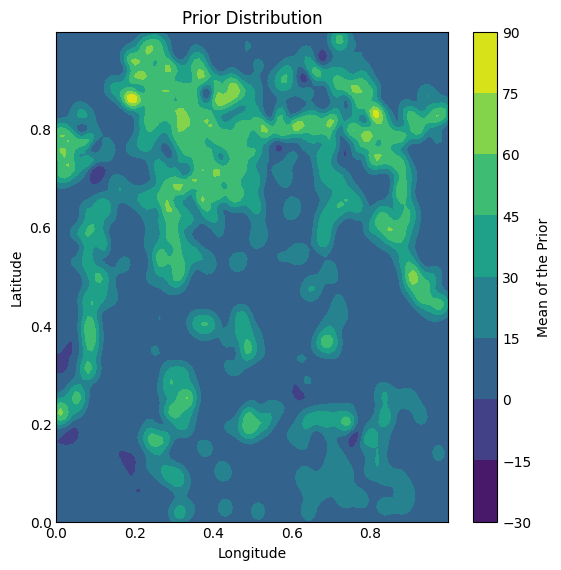

In [29]:
x_test_prior = np.linspace(area_data.loc[store_idx, 'lon'].min(), area_data.loc[store_idx, 'lon'].max(), 100)
y_test_prior = np.linspace(area_data.loc[store_idx,'lat'].min(), area_data.loc[store_idx,'lat'].max(), 100)

X_test_prior, Y_test_prior = np.meshgrid(x_test_prior, y_test_prior)
test_points_mean = np.c_[X_test_prior.ravel(), Y_test_prior.ravel()]

mean_prior, std_prior = gp_model.predict(test_points_mean, return_std=True)

mean_prior = mean_prior.reshape(X_test_prior.shape)
std_prior = std_prior.reshape(X_test_prior.shape)

# Plot the mean of the prior Distribution
plt.figure(figsize=(5, 5))
plt.contourf(X_test_prior, Y_test_prior, mean_prior, cmap=cm.viridis)
plt.colorbar(label='Mean of the Prior')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Prior Distribution')
# plt.show()

# Gaussian Process

In [30]:
# Split the data
# Used a small sample set to test and run the Gaussian Process
X_train, X_test, y_train, y_test = train_test_split(area_data[['lon', 'lat']], concentration_data['pm25'], test_size=0.95, random_state=0)

# Here I want to split the test Data set again:
X_test_1, X_test_2, y_test_1, y_test_2 = train_test_split(X_test, y_test, test_size=0.95, random_state=0)

# RBF Kernel and Gaussian Process with arbitrary used Hyperparameter
# Note: I used the RBF Kernel but basically we have to test different kernels to understand the data!
# After we found the right Kernel we should find ideal Hyperparameter values!
# The kernel that fits best gives as inisghts bout the data, in terms of periodicity, or other relationships!
kernel = 1.0 * RBF(length_scale=0.5)
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp_model.fit(X_train, y_train)

# Our goal is to maximize the marignal likelihood
log_likelihood = gp_model.log_marginal_likelihood()

# Testing Model with a small set!
y_pred, sigma = gp_model.predict(X_test_1, return_std=True)

# Analysis of the Gaussian Process

/home/yannick/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


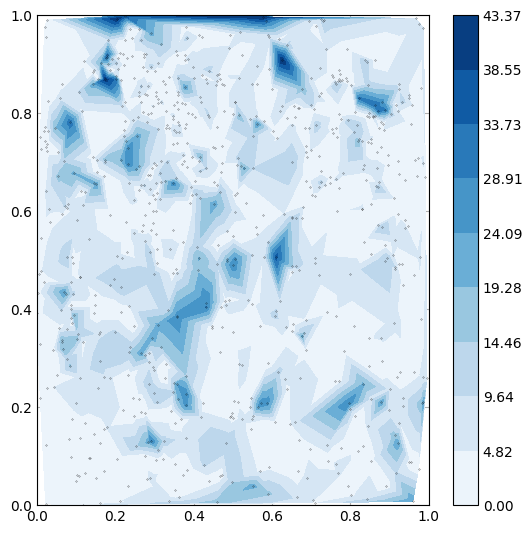

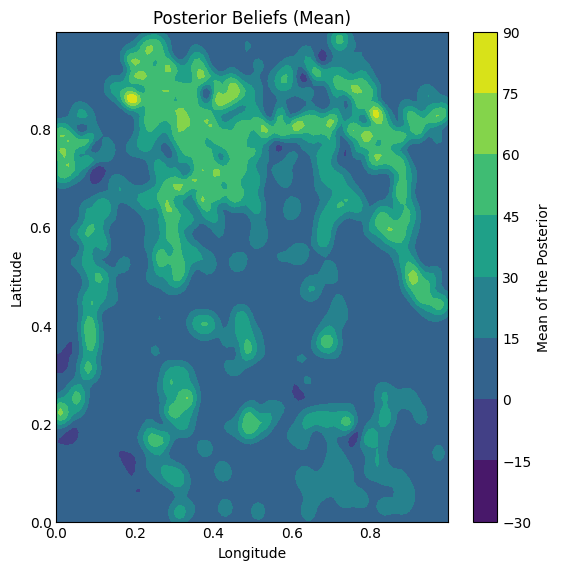

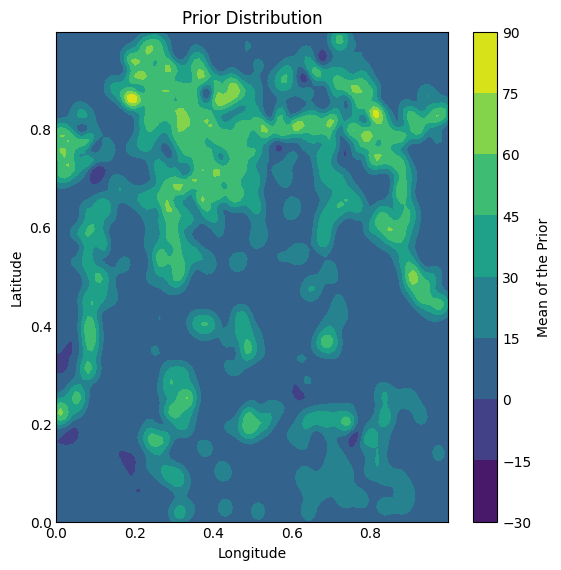

In [31]:
error = abs(y_pred - y_test_1)

# Plot: 2D Representation of the ERROR!
levels = np.linspace(error.min(), error.max(), 10)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X_test_1['lon'], X_test_1['lat'], 'o', markersize=0.2, color='black')
tgf = ax.tricontourf(X_test_1['lon'], X_test_1['lat'], error, levels=levels)
ax.set(xlim=(0, 1), ylim=(0, 1))
fig.colorbar(tgf)
# plt.show()

# Posterior Calculation:
mean_post, std_post = gp_model.predict(test_points, return_std=True)

mean_post = mean_post.reshape(X_test_prior.shape)
std_post = std_post.reshape(X_test_prior.shape)

# Note: I need to check it for the same points?????
# Plot the mean of the posterior
plt.figure(figsize=(5, 5))
plt.contourf(X_test_prior, Y_test_prior, mean_post, cmap=cm.viridis)
plt.colorbar(label='Mean of the Posterior')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Posterior Distribution')

# Plot the mean of the prior
plt.figure(figsize=(5, 5))
plt.contourf(X_test_prior, Y_test_prior, mean_prior, cmap=cm.viridis)
plt.colorbar(label='Mean of the Prior')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Prior Distribution')

# Why is there no difference visible???

plt.show()